**MDS7203 Modelos Generativos Profundos, Primavera 2023**

# Laboratorio 4: Modelos basados en Score

**Profesor**: Felipe Tobar

**Auxiliares**: Cristóbal Alcázar, Camilo Carvajal Reyes.
**Ayudante**: Joaquín Barceló.

**Fecha de entrega**: 6 de noviembre 2023

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import math

## Pregunta 1. Muestreo de Langevin

El objetivo de esta pregunta será explorar visualmente la naturaleza del muestreo con el método *Langevin dynamics*, que es aquel usado para generar puntos de datos con modelos de score. Para esto usaremos mixturas de gaussianas, i.e., modelos que cumplen que la densidad de un punto $x\in\mathbb{R}^d$ está dada por

$$p(x)=\sum_{k=1}^K\alpha_k\frac{1}{\sqrt{(2\pi)^d\mathrm{det}(\Sigma_k)}}e^{-\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k)},$$

donde $\Sigma_k$ es definida positiva para todo $k=1,\ldots,K$ y $\sum_{k=1}^K\alpha_k=1$.

### a)

Defina una clase *GaussianMixture*. Considere que esta debe instanciarse tomando los parámetros de las distribuciones gaussianas que la componen, incluyendo el peso de cada componente. Incluya los métodos que le parezcan adecuados.

In [2]:
class GaussianMixture:
    def __init__(self, means, covariances, weights):
        """
        Inicializa una mezcla de gaussianas

        Parameters:
        -----------
        means: list(np.array)
            Lista de vectores de medias de las gaussianas
        covariances: list(np.array) 
            Lista de matrices de covarianza de las gaussianas
        weights: list(float) 
            Lista de pesos de las gaussianas (deben sumar 1)
        """
        
        self.means = means
        self.covariances = covariances
        self.weights = weights
        self.K, self.d = len(means), len(means[0])

    def pdf(self, x):
        """
        Calcula la densidad de probabilidad en el punto x, es decir, p(x)

        Parameters:
        -----------
        x: np.array
            Un vector en R^d

        Returns:
        --------
        pdf_value: float
            Valor de p(x)
        """
        
        # Calculamos pdf para cada normal
        component_pdfs = np.array([
            multivariate_normal.pdf(x, mean=self.means[k], cov=self.covariances[k]) 
            for k in range(self.K)
        ])
        
        # Suma ponderada por los pesos                           
        pdf_value = np.sum(self.weights * component_pdfs)
            
        return pdf_value

    def sample(self, num_samples, random_state=42):
        """
        Genera muestras de la mezcla de gaussianas
        
        Parameters:
        -----------
        num_samples: int
            Número de muestras a samplear
        random_state: int
            Semilla

        Returns:
        --------
        samples: np.array
            Muestras generadas (matriz de num_samples x d)
            Cada fila es una muestra
        """
        np.random.seed(random_state)
        
        samples = np.zeros((num_samples, self.d))
        
        # Escogemos las normales de las cuales samplear
        component_indices = np.random.choice(a=self.K, size=num_samples, p=self.weights)
        
        # Sampleamos cada muestra
        for i in range(num_samples):
            k = component_indices[i]
            sample = np.random.multivariate_normal(self.means[k], self.covariances[k])
            samples[i, :] = sample
        return samples

    def get_parameters(self):
        """
        Obtiene los parámetros de la mezcla de gaussianas

        Returns:
        --------
        parameters: dict(np.array)
            Diccionario que contiene las medias, varianzas y pesos
        """
        
        parameters = {
            "medias": self.means,
            "covarianzas": self.covariances,
            "pesos": self.weights
        }
        
        return parameters

### b)

Exprese la función de *score* para una mixtura de gaussianas en función de un punto $x\in\mathbb R^d$. Implemente un nuevo método para la clase *GaussianMixture* que retorne el vector de *score* en cuestión dado $x$.

>Reescribiendo la densidad de la mixtura de gaussianas como
>
>$$p(x)=\sum_{k=1}^K\alpha_k\mathcal N(x|\mu_k,\Sigma_k),$$
>
>tenemos que
>
>$$\nabla_x\log p(x)=\frac{1}{p(x)}\nabla_x p(x)=\frac{1}{p(x)}\sum_{k=1}^K{\alpha_k}\nabla_x\mathcal N(x|\mu_k,\Sigma_k)=\frac{1}{p(x)}\sum_{k=1}^K\alpha_k\cdot\Big(-\Sigma_k^{-1}(x-\mu_k)\cdot\mathcal N(x|\mu_k,\Sigma_k)\Big),$$
>
>donde basta recordar que el gradiente de la forma cuadrática $f(y)=y^TAy$ es $\nabla f(y)=(A+A^T)y$, y que $\Sigma_k^{-1}$ es una matriz simétrica, por lo que 
>
>$$\nabla_x\big(e^{-\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k)}\big)= e^{-\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k)}\cdot\nabla_x\Big(-\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k)\Big)=-e^{-\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k)}\cdot\Sigma_k^{-1}(x-\mu_k).$$

In [3]:
def score(self, x):
    """
    Calcula el score en el punto x, es decir, nabla(log p(x))

    Parameters:
    -----------
    x: np.array
        Un vector en R^d

    Returns:
    --------
    score_vector: float
        Valor de nabla(log(p(x)))
    """

    score_vector = np.zeros_like(x)

    # Obtenemos p(x)
    px = self.pdf(x)

    # Calculamos el gradiente de las normales
    for k in range(self.K):
        component_pdf = multivariate_normal.pdf(x, mean=self.means[k], cov=self.covariances[k])
        # Usamos np.linalg.solve para obtener la solución z del sistema Sigma_k*z = x-mu_k, es decir, z=Sigma_k^{-1}*(x-mu_k)
        # Esto es más eficiente que calcular la inversa de Sigma_k
        component_score = - (self.weights[k] / px) * component_pdf * np.linalg.solve(self.covariances[k], (x - self.means[k]))
        score_vector += component_score

    return score_vector

# Agregamos el método a la clase
GaussianMixture.score = score

### c)

Usando su clase, defina una mixtura de tres Gaussianas en $\mathbb{R}^2$ y visualice tanto su densidad como su función de score. Las gaussianas de base deberán cumplir que al menos esté “suficientemente alejada” de las otras y que los pesos de las componentes sean “suficientemente variados”.

In [4]:
# Definimos medias, covarianzas y pesos de la mixtura gaussiana
means = [
    np.array([0, 0]), 
    np.array([5, 8]), 
    np.array([10, 0])
]

covariances = [
    np.array([[1, 0], 
              [0, 1]]), 
    np.array([[1, 0.5], 
              [0.5, 2]]), 
    np.array([[2, 0], 
              [0, 1]])
]

weights = [0.6, 0.1, 0.3]

# Creamos una instancia de la clase
gm = GaussianMixture(means, covariances, weights)

# Sampleamos datos
train_data = gm.sample(200)

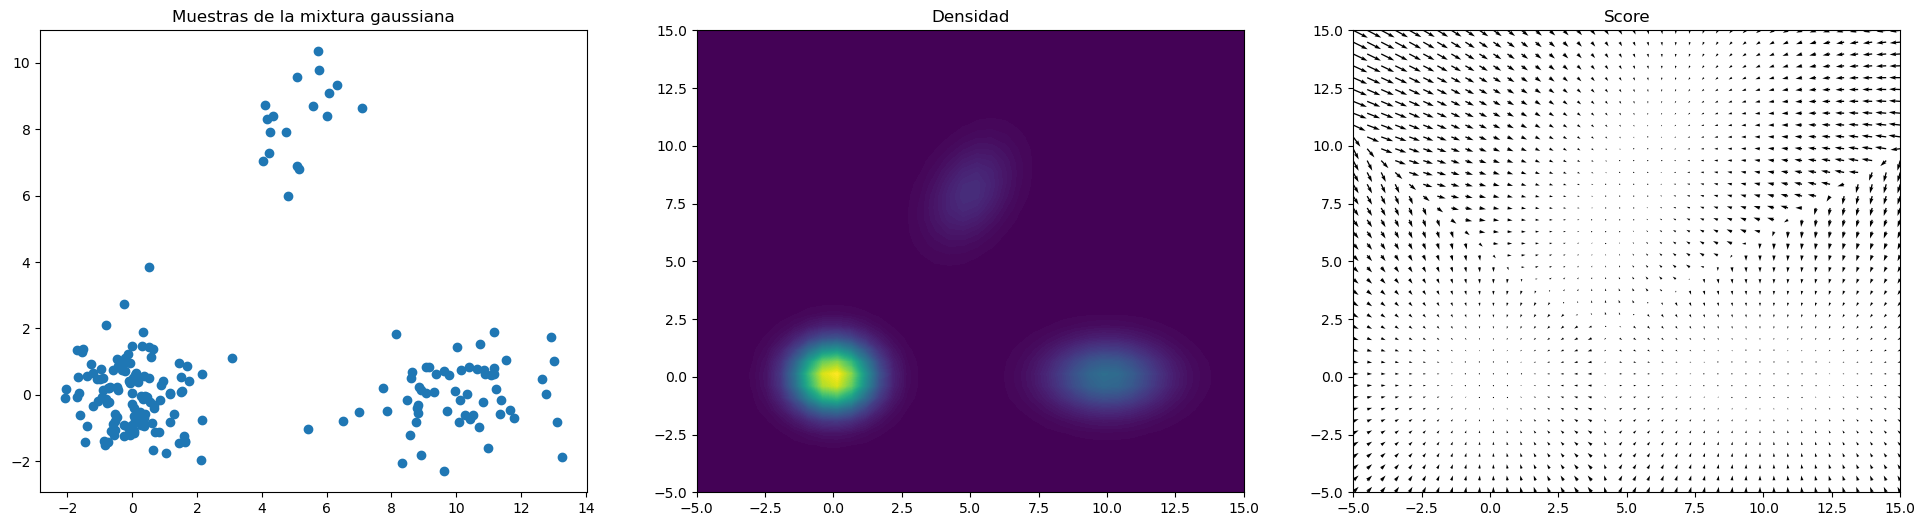

In [5]:
num_of_points = 40

# Creamos una grilla en R^2
x, y = np.meshgrid(np.linspace(-5, 15, num_of_points), np.linspace(-5, 15, num_of_points))
grid = np.vstack((x.flatten(), y.flatten())).T

# Calculamos la densidad y el score para cada punto de la grilla
# No funciona hacer gm.pdf(grid) ni gm.score(grid)
pdf_values = np.array([gm.pdf(x) for x in grid]).reshape(num_of_points, num_of_points)
score_vectors = np.array([gm.score(x) for x in grid])

# Graficamos
fig, (sample_plot, density_plot, score_plot) = plt.subplots(nrows=1, ncols=3, figsize=(24,6))

sample_plot.scatter(train_data[:, 0], train_data[:, 1])
sample_plot.set_title('Muestras de la mixtura gaussiana')

density_plot.contourf(x, y, pdf_values, levels=100, cmap='viridis')
density_plot.set_title('Densidad')

score_plot.quiver(grid[:, 0], grid[:, 1], score_vectors[:, 0], score_vectors[:, 1], scale=500)
score_plot.set_title('Score')

plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.savefig('images/p1c.pdf', bbox_inches='tight')
plt.show()

### d)

Implemente el método *Langevin dynamics* usando algún paso $\varepsilon$ fijo, un número de pasos $T$ y una distribución prior $\pi(x)$ adecuada. Genere y grafique muestras usando el método y las gaussianas de la parte anterior. Incluya tanto un análisis de sus visualizaciones como una explicación de la intuición detrás de la actualización del método. Incluya una visualización de las trayectorias que siguen los puntos.

In [6]:
def langevin_dynamics(self, epsilon, T, random_state=42):
    """
    Genera una trayectoria usando Langevin Dynamics

    Parameters:
    -----------
    epsilon: float
        Paso de Langevin Dynamics
    T: int
        Número de pasos
    random_state: int
        Semilla

    Returns:
    --------
    x: np.array
        Trayectoria de x_t durante los T pasos
    """
    
    np.random.seed(random_state)
    
    # Definimos punto inicial
    xt = np.random.uniform(-5, 15, size=self.d)
    trajectory = [xt]
    
    # Iteramos
    for t in range(T):
        # Obtenemos score de x_t
        score = self.score(xt)
        
        # Sampleamos z_t normal N(0, sqrt(2*epsilon))
        zt = np.random.normal(0, np.sqrt(2*epsilon), xt.shape)
        
        # Hacemos el paso y agregamos
        xt = xt + epsilon * score + zt
        trajectory.append(xt)
    return np.array(trajectory)

# Agregamos el método a la clase
GaussianMixture.langevin_dynamics = langevin_dynamics

In [7]:
# Definimos parámetros y usamos prior uniforme
epsilon = 0.05
T = 100
n_samples = 40

# Generamos muestras usando Langevin Dynamics
trajectories = [gm.langevin_dynamics(epsilon, T, random_state=42+i) for i in range(n_samples)]

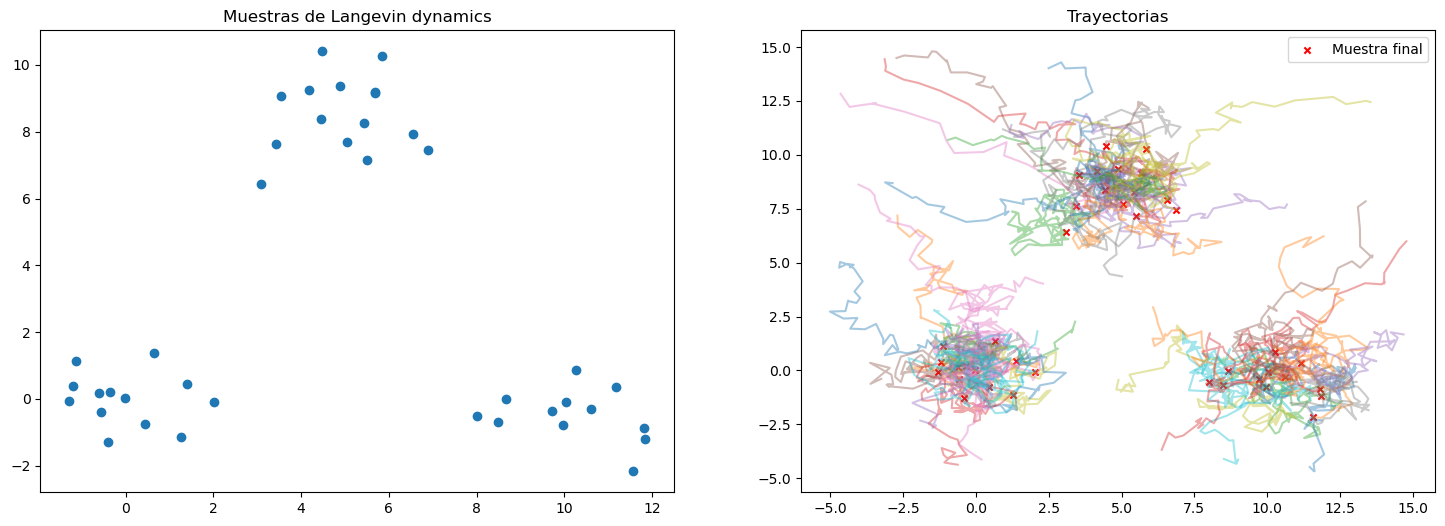

In [8]:
# Graficamos las trayectorias y las muestras en tiempo T
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

for i in range(n_samples):
    trajectory = trajectories[i]
    
    ax1.scatter(trajectory[-1, 0], trajectory[-1, 1], c='tab:blue')
    ax1.set_title('Muestras de Langevin dynamics')
    
    ax2.scatter(trajectory[-1, 0], trajectory[-1, 1], c='r', marker='x', s=20, label='Muestra final' if i==0 else "")
    ax2.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.4)
    ax2.set_title('Trayectorias')

plt.legend()
plt.savefig('images/p1d.pdf', bbox_inches='tight')
plt.show()

>Podemos ver que las muestras generadas por Langevin Dynamics llegan a aproximar las muestras de la mixtura gaussiana definida anteriormente. Esto funciona debido a que dado un punto inicial, en cada paso nos movemos en la dirección dada por el score, y viendo el gráfico de scores vemos que estas direcciones apuntan a las guassianas de la mixtura hasta que el score es nulo en estas regiones, por lo que es esperable que siguiendo estas direcciones se obtengan buenas muestras de la mixtura gaussiana.
>
>El problema que podemos tener con este método es que podemos tener otras regiones con score nulo que no son las gaussianas, lo que puede provocar que las muestras se queden estancadas en ciertas zonas donde la distribución tiene baja densidad, y por lo tanto, no converjan a una buena muestra.

## Pregunta 2. Denoising Score matching y Annealed Langevin

Considere la divergencia de Fisher, dada por

$$F(p,q)=\mathbb{E}_{p(x)}\left[\|\nabla_x\log p(x)-\nabla_x\log q(x)\|_{2}^2\right]$$

A continuación denotaremos por $s_\theta(x)$ a nuestra aproximación de $\nabla_x\log p(x)$.

### a) 

Explique cómo nos acercamos a la distribución de los datos a través de la función de score usando la divergencia de Fisher. ¿Qué problema tiene usarla directamente como función de costo?

>Notemos que la divergencia de Fisher $F(p,q)$ está comparando el score de las distribuciones $p(x)$ y $q(x)$, y como vimos en la pregunta anterior, estas direcciones nos llevan a las zonas donde se concentras estas distribuciones, de este modo, si la divergencia de Fisher es baja, entonces las distribuciones se parecen entre sí debido a que usando Langevin Dynamics obtendríamos muestras de ambas distribuciones en casi las mismas regiones
>
>El problema que presenta utilizar directamente la divergencia de Fisher en este caso es lo mencionado en la parte anterior, si bien se puede aproximar la distribución mediante score en las regiones de alta densidad, la aproximación falla en regiones de baja densidad.

Nos referiremos a *denoising score matching* cuando minimizamos

$$\ell(\theta;\sigma)=\frac{1}{2}\mathbb E_{q_\sigma(\tilde x|x)p(x)}\left[\|s_\theta(\tilde x)-\nabla_{\tilde x}\log q_\sigma(\tilde x|x)\|_{2}^2\right]$$

para un $\sigma$ dado. Usaremos esto para minimizar un objetivo dependiente de una secuencia de ruido fija $\{\sigma_t\}_{t=1}^T$:

$$\mathcal L(\theta;\{\sigma_t\}_{t=1}^T)=\frac{1}{T}\sum_{t=1}^T\lambda(\sigma_t)\ell(\theta;\sigma_t).$$

Una red neuronal $s_\theta(x,\sigma)$ que dependa también del nivel de ruido y minimizando el objetivo
anterior se denotará *noise conditional score network*.

### b)

Reescriba la función de pérdida de la ecuación anterior usando un proceso de ruido gaussiano 

$$q_\sigma(\tilde x|x)=\frac{1}{\sigma\sqrt{(2\pi)}^d}e^{-\frac{1}{2\sigma^2}(\tilde x-x)^T(\tilde x-x)}.$$

Explique como aproximar las esperanzas en la práctica e implemente con esto una función de pérdida que tome un punto de dato $x\in\mathbb R$, un modelo de pytorch (una clase heredada de nn.Module) y otros parámetros que estime conveniente.

>Tenemos que
>
>$$\nabla_{\tilde x}\log q_\sigma(\tilde x|x)=\frac{1}{q_\sigma(\tilde x|x)}\nabla_{\tilde x} q_\sigma(\tilde x|x)=\frac{1}{q_\sigma(\tilde x|x)}q_\sigma(\tilde x|x)\nabla_{\tilde x}\left(-\frac{1}{2\sigma^2}\|\tilde x-x\|_2^2\right)=-\frac{(\tilde x-x)}{\sigma^2}.$$
>
>Luego
>
>$$\ell(\theta;\sigma)=\frac{1}{2}\mathbb E_{q_\sigma(\tilde x|x)p(x)}\left[\left\|s_\theta(\tilde x)+\frac{(\tilde x-x)}{\sigma^2}\right\|_2^2\right].$$
>
>Para aproximar la esperanza utilizamos una estimación de Monte Carlo sampleando muestras $\tilde x_i$ de $q_\sigma(\tilde x|x)$ dado un punto de dato $x\in\mathbb R$, de modo que si $\{\tilde x_i\}_{i=1}^N$ son muestras, entonces
>
>$$\mathbb E_{q_\sigma(\tilde x|x)p(x)}\left[\left\|s_\theta(\tilde x)+\frac{(\tilde x-x)}{\sigma^2}\right\|_2^2\right]\approx\frac{1}{N}\sum_{i=1}^N\left\|s_\theta(\tilde x_i)+\frac{(\tilde x_i-x)}{\sigma^2}\right\|_2^2.$$
>
>Por lo tanto
>
>$$\mathcal L(\theta;\{\sigma_t\}_{t=1}^L=\frac{1}{L}\sum_{t=1}^L\sigma_t^2\ell(\theta;\sigma_t)=\frac{1}{2LN}\sum_{t=1}^L\sum_{i=1}^N\sigma_t^2\left\|s_\theta(\tilde x_i)+\frac{(\tilde x_i-x)}{\sigma^2}\right\|_2^2,$$
>
>donde usamos que $\lambda(\sigma_t)=\sigma_t^2$.

In [9]:
def denoising_score_matching_loss(x, model, sigma, num_samples, random_state=42):
    """
    Calcula la función de pérdida para Denoising Score Matching

    Parameters:
    -----------
    x: torch.Tensor()
        Punto de dato en R^d
    model: Modelo de nn.Module
        Modelo de score s_\theta
    sigma: float
        Nivel de ruido para x
    num_samples: int
        Número de muestras para Monte Carlo
    random_state: int
        Semilla

    Returns:
    --------
    loss: float
        Función de pérdida
    """
    torch.manual_seed(random_state)
    
    d = x.shape[0]
    
    # Generamos num_samples muestras \tilde x_i perturbando x
    z = torch.randn(size=(num_samples,d))
    tilde_x = x + sigma * z

    # Calculamos s_\theta(\tilde x_i)
    model_score = model(tilde_x)

    # Calcular el término de la pérdida
    loss_term = torch.norm(model_score + (1 / sigma ** 2) * (tilde_x - x), dim=1) ** 2
    loss = torch.mean(loss_term)

    return loss

def loss_function(x, model, sigmas, num_samples, random_state=42):
    loss = 0
    for i, sigma in enumerate(sigmas):
        loss += sigma ** 2 * denoising_score_matching_loss(x, model, sigma, num_samples, random_state=42) 
        
    return loss / len(sigmas)

### c)

Para alguna secuencia de ruido apropiada (justifique en base a la literatura de la unidad), seleccione algunos niveles y grafique su mixtura de gaussiana inyectada con ruido. Comente y justifique la idea de usar ruido al aprender la función de score.

>Elegimos una secuencia $\sigma_1<\sigma_2<\cdots<\sigma_L$ que siguen una progesión geométrica ([Fuente](https://yang-song.net/blog/2021/score/)), donde $\sigma_1$ es suficientemente pequeño y $\sigma_L$ es comparable a la máxima distancia entre los puntos de datos.

In [10]:
# Secuencia de ruido
L = 10
sigma_1 = 0.01
sigma_L = 10
sigmas = np.geomspace(sigma_1, sigma_L, L)

noisy_data = {}

for i, sigma in enumerate(sigmas):
    z = np.random.randn(len(train_data), 2)
    noisy_data[i] = train_data + sigma * z

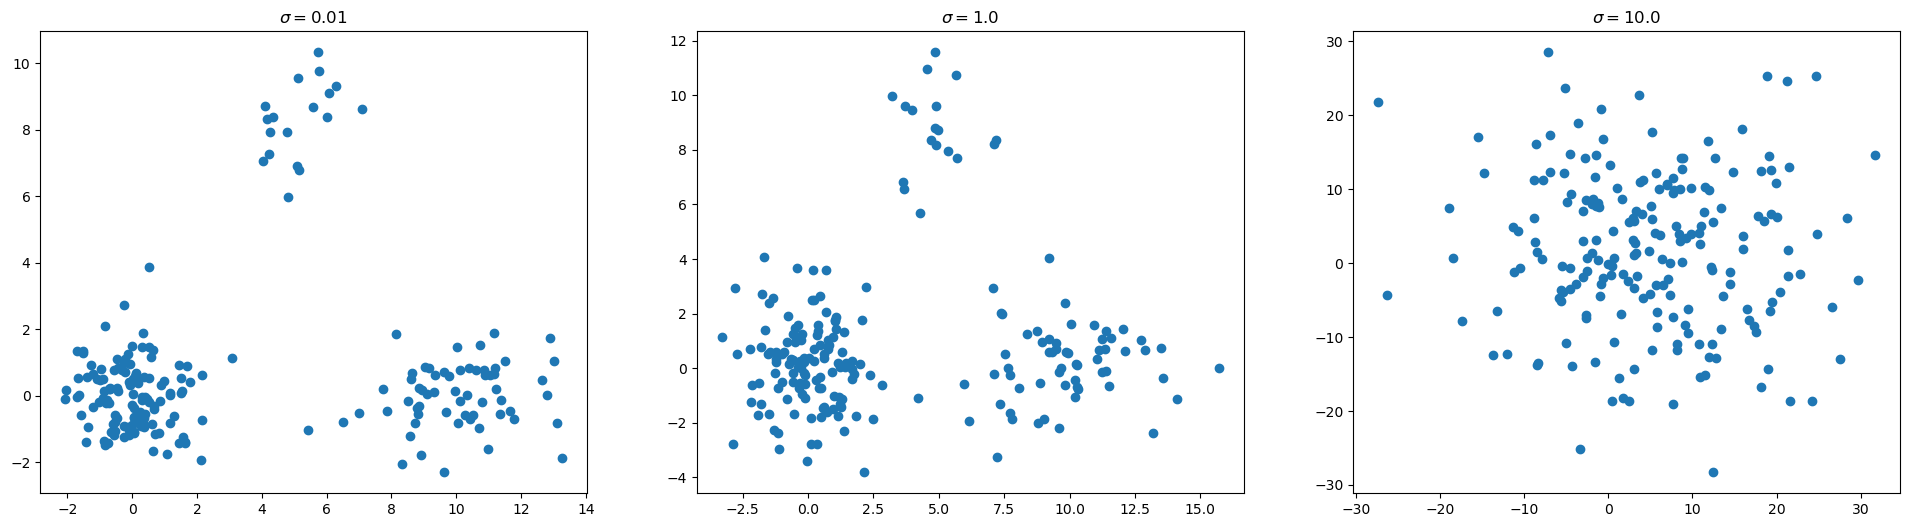

In [11]:
# Graficamos
fig, (sigma_1_plot, sigma_i_plot, sigma_L_plot) = plt.subplots(nrows=1, ncols=3, figsize=(24,6))

sigma_1_plot.scatter(noisy_data[0][:, 0], noisy_data[0][:, 1])
sigma_1_plot.set_title(f'$\sigma=${sigmas[0]}')

sigma_i_plot.scatter(noisy_data[2*(L-1)//3][:, 0], noisy_data[2*(L-1)//3][:, 1])
sigma_i_plot.set_title(f'$\sigma=${sigmas[2*(L-1)//3]}')

sigma_L_plot.scatter(noisy_data[L-1][:, 0], noisy_data[L-1][:, 1])
sigma_L_plot.set_title(f'$\sigma=${sigmas[L-1]}')

plt.savefig('images/p2c.pdf', bbox_inches='tight')
plt.show()

>La idea de aplicar ruido al aprender la función de score es evitar los problemas que surgen al utilizar Langevin Dynamics directamente, de modo que no hayan regiones con densidad nula. Además, en este caso particular, aplicar ruido gaussiano también permite que la distribución tenga como soporte todo el espacio evitando así el problema de *the manifold hypothesis*.

### d)

Implemente el algoritmo *Annealed Langevin dynamics* de modo que use su función de *score* dependiente del ruido.

In [12]:
def annealed_langevin_dynamics(model, sigmas, epsilon, T, random_state=42):
    """
    Genera una trayectoria usando Langevin Dynamics

    Parameters:
    -----------
    model: nn.Module()
        Red neuronal que representa el score
    sigmas: list(float)
        Secuencia de ruido
    epsilon: float
        Paso de Langevin Dynamics
    T: int
        Número de pasos
    random_state: int
        Semilla

    Returns:
    --------
    x: np.array
        Trayectoria de x_t durante los T pasos
    """
    torch.manual_seed(random_state)
    
    # Definimos punto inicial de manera uniforme
    xt = torch.torch.distributions.Uniform(low=-5, high=15).sample((2,))
    trajectory = [xt]
    
    # Iteramos
    for i, sigma in enumerate(sigmas):
        alpha = epsilon * sigma ** 2 / sigmas[-1] ** 2
        for t in range(T):
            # Sampleamos z_t normal N(0, sqrt(alpha))
            zt = np.random.normal(0, np.sqrt(alpha), xt.shape)
            zt = torch.tensor(zt, dtype=torch.float32)
            
            # Obtenemos score de x_t, sigma_i
            score = model(xt) / sigma
        
            # Hacemos el paso y agregamos
            xt = xt + alpha * score / 2 + zt
            trajectory.append(xt)
        
        xt = trajectory[-1]
            
    return trajectory[-1]

### e)

Pruebe su algoritmo muestreando de su mixtura gaussiana de la parte anterior y usando algún modelo simple. Usando la función de pérdida defina un bucle de entrenamiento y entrene el modelo. Detalle sus observaciones.

In [13]:
def get_timestep_embedding(timesteps, embedding_dim):
    """
    Embeddings posicionales sinusoidales
    Fuente: https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/nn.py
    """
    
    assert len(timesteps.size()) == 1

    half_dim = embedding_dim // 2
    emb = torch.arange(half_dim, dtype=torch.float32)
    emb = torch.exp(emb * (-math.log(10000) / (half_dim)))
    emb = timesteps.view(-1, 1) * emb.view(1, -1)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

    if embedding_dim % 2 == 1:  # zero pad
        emb = F.pad(emb, (0, 1))

    assert emb.shape == (timesteps.size(0), embedding_dim) 
    return emb

In [14]:
# Número de neuronas por capa
NLAYERS_1 = 32
NLAYERS_2 = 16

# Definimos la noise conditional score network
class NCSN(nn.Module):
    def __init__(self, input_dim):        
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim, NLAYERS_1)
        self.fc2 = nn.Linear(NLAYERS_1, NLAYERS_2)
        self.fc3 = nn.Linear(NLAYERS_2, input_dim)

    def forward(self, x):
        h_1 = F.relu(self.fc1(x))
        h_2 = F.relu(self.fc2(h_1))
        
        return self.fc3(h_2)

def train(model, sigmas, iterator, optimizer, device):
    epoch_loss = 0

    model.train()

    for x in iterator:
        x = x.to(device)

        optimizer.zero_grad()    
        loss = loss_function(x, model, sigmas, 100, random_state=42)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [15]:
# Procesamos la data
BATCH_SIZE = 1
train_data = torch.tensor(train_data, requires_grad=True, dtype=torch.float32)
train_iterator = data.DataLoader(train_data, batch_size=BATCH_SIZE)

In [16]:
# Definimos la secuencia de ruidos
L = 10
sigma_1 = 0.01
sigma_L = 10
sigmas = np.geomspace(sigma_1, sigma_L, L)

# Inicializamos el modelo
INPUT_DIM = 2
model = NCSN(INPUT_DIM)

# Inicializamos el optimizador
LEARNING_RATE = 0.01
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Pasamos todo a device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Entrenamos
EPOCHS = 50
train_loss_list = []

for epoch in range(EPOCHS):
    train_loss = train(model, sigmas, train_iterator, optimizer, device)
    
    train_loss_list.append(train_loss)

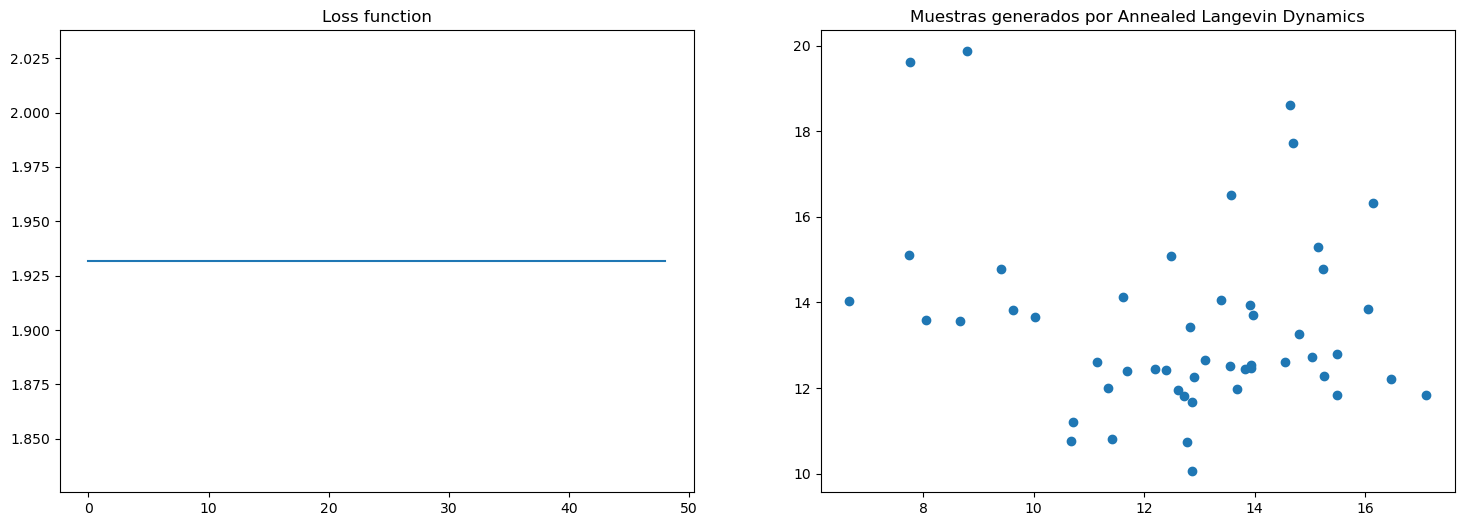

In [17]:
samples = [annealed_langevin_dynamics(model, sigmas, epsilon, T, random_state=42) for i in range(50)]
samples = np.array([sample.detach().numpy() for sample in samples])

# Graficamos
fig, (loss_plot, samples_plot) = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

loss_plot.plot(train_loss_list[1:])
loss_plot.set_title('Loss function')

samples_plot.scatter(samples[:, 0], samples[:, 1])
samples_plot.set_title('Muestras generados por Annealed Langevin Dynamics')

plt.savefig('images/p2e.pdf', bbox_inches='tight')
plt.show()

>Podemos ver que la función de pérdida se queda atascada en 1.9 y desciende de manera muy lenta, además las muestras generadas por Annealed Langevin Dynamics no se corresponden con las de nuestra mixtura gaussiana, por lo que tenemos un problema en la implementación. En particular, en la Noise Conditional Score Network (NCSN) debemos tener una forma de procesar el ruido $\sigma$ que estamos aplicando en cada etapa. Esto se puede lograr mediante un encoder posicional, codificando el tiempo, es decir, considerar la red como $s_\theta(x,i)$, y que la red aprenda a que avanzar en el tiempo significa que estamos aumentando el ruido, pues de otro modo con $s_\theta(x)$ la red no tendría una forma de saber qué ruido aplicar, lo que podemos verificar con las muestras entregadas por el algoritmo, que parecen ser muestras correspondientes a la gaussiana de mayor ruido.

## Pregunta 3. Generalización con ecuaciones diferenciales estocásticas

Los conceptos de las preguntas anteriores pueden generalizar a una inyección continua de tiempo. Haremos esto a través de ecuaciones diferenciales estocásticas (SDEs por sus siglas en inglés). La configuración discreta del algoritmo *annealed Langevin dynamics* corresponde a la discretización de la SDE: $dx=\sqrt{\frac{d}{dt}\sigma(t)^2}dW_t$, donde $W_t$ denota el proceso de Wiener o movimiento browniano.

En general, consideraremos SDEs de la forma

$$dx=f(x,t)dt+g(t)dW_t$$

donde $f(\cdot,t):\mathbb R^d\to\mathbb R^d$ es una función usualmente llamada como coeficiente de *drift* y donde $g:\mathbb R\to\mathbb R$ es una función escalar denotada coeficiente de difusión de $x(t)$. Se demostró que un proceso como el de la ecuación anterior cumple que su proceso reverso (i.e., de adelante hacia atrás en el tiempo) corresponde a la siguiente SDE:

$$dx=\left[f(x,t)-g(t)^2\nabla_x\log p(x)\right]dt+g(t)d\overline W_t$$

donde $\overline W_t$ corresponde al proceso de Wiener pero con el tiempo yendo de $T$ a $0$.

### a)

Implemente una clase *SDE* con los atributos que usted considere necesarios. Escriba un método que retorne el coeficiente de *drift* de la SDE reversa en el tiempo.

In [18]:
class SDE:
    def __init__(self, f, g):
        """
        Inicializa una SDE con coeficientes de drift y difusión dados

        Parameters:
        -----------
        f: function
            Coeficiente de drift f(x, t)
        g: function
            Coeficiente de difusión g(t)
        """
        
        self.f = f
        self.g = g

    def get_drift_coefficient_reverse(self, x, t, score):
        """
        Calcula el coeficiente de drift de la SDE inversa

        Parameters:
        -----------
        x: np.array
            Posición
        t: float
            Tiempo
        score: np.array
            Gradiente del logaritmo de p(x)

        Returns:
        --------
        drift_reverse: np.array
            Coeficiente de drift de la SDE inversa en el tiempo
        """
        
        drift_reverse = self.f(x, t) - self.g(t) ** 2 * log_density_gradient
        return drift_reverse

Nos interesará, en esta parte, usar el proceso de Ornstein–Uhlenbeck, que está dado por

$$dx=-\frac{1}{2}x_tdt+dW_t.$$

### b) 

Describa propiedades del proceso de Ornstein–Uhlenbeck.

>El proceso de Ornstein-Uhlenbeck es un proceso con aplicaciones en matemáticas financieras. Es un proceso estacionario de Gauss-Markov, es decir, es un proceso Gaussiano que cumple la propiedad de Markov y es temporalmente homogéneo.
>
>De manera general, este proceso está dado por la SDE: $$dx=\theta(\mu-x_t)dt+\sigma dW_t.$$
>
>Este proceso cumple que $\mathbb E(x_t|x_0)=x_0e^{-\theta t}+\mu(1-e^{-\theta t})$ y $\mathrm{cov}(x_t,x_s)=\frac{\sigma^2}{2\theta}\big(e^{-\theta|t-s|}-e^{-\theta(t+s}\big)$, es decir, el proceso tiene autocorrelación exponencial, de modo que las valores dejan de estar correlacionadas mientras más separados estén en el tiempo.

### c)

Implemente una clase *SDE* específica para esta SDE.

In [19]:
class OrnsteinUhlenbeckSDE:
    # Fuente: https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process
    def __init__(self, theta=0.5, mu=0, sigma=1):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma

    def drift(self, x):
        """
        Calcula el coeficiente de drift

        Parameters:
        -----------
        x: float
            Posición

        Returns:
        --------
        drift: float
            Coeficiente de drift
        """
        
        return self.theta * (self.mu - x)

    def diffusion(self):
        """
        Calcula el coeficiente de difusión

        Returns:
        --------
        diffusion: float
            Coeficiente de difusión
        """
        
        return self.sigma
    
    def simulate(self, x0, dt, num_steps, random_state=42):
        """
        Simula una trayectoria del proceso de Ornstein-Uhlenbeck

        Parameters:
        -----------
        x0: np.array
            Punto inicial
        dt: float
            Paso temporal
        num_steps: int
            Número de pasos
        random_state: int 
            Semilla
    
        Returns:
        --------
        - trajectory: np.array
            Trayectoria simulada
        """
        np.random.seed(random_state)
        
        x = x0
        trajectory = np.zeros(num_steps)
        
        for i in range(num_steps):
            x += self.drift(x) * dt + self.diffusion() * np.sqrt(dt) * np.random.normal()
            trajectory[i] = x
            
        return trajectory

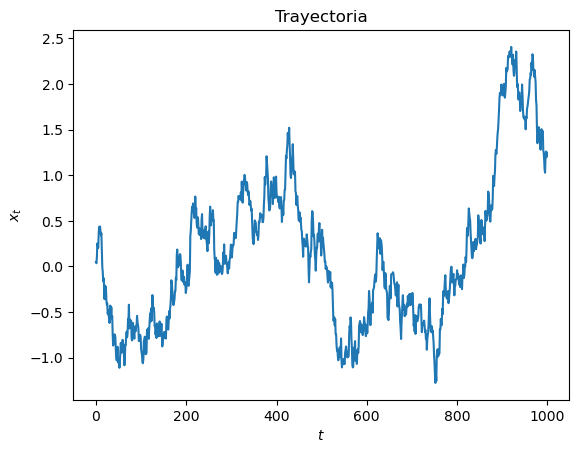

In [20]:
# Generamos una instancia de la SDE
process = OrnsteinUhlenbeckSDE()

# Simulamos una trayectoria
x0 = 0
dt = 0.01
num_steps = 1000
trajectory = process.simulate(x0, dt, num_steps)

# Graficamos
plt.plot(trajectory)
plt.title("Trayectoria")
plt.xlabel("$t$")
plt.ylabel("$x_t$")
plt.show()

Para poder resolver numéricamente ecuaciones diferenciales estocásticas existen algunos métodos numéricos. Uno de los más comunes es el de Euler-Maruyama, que consiste en aproximar la SDE de la ecuación 2 por trayectorias definidas recursivamente por:

$$x_{t+1}=x_t+f(x,t)\Delta t+g(t)z_t,~\text{con }z_t\sim\mathcal N(0,\Delta tI).$$

En lo anterior comenzamos con un punto $x_0\sim\pi(x)$ y consideramos la partición del espacio
temporal $0=t_1,t_2,\ldots,t_{N-1},t_N=T$ con paso uniforme $\Delta t=\frac{T}{N}$.

### d) 

Implemente la discretización de Euler-Maruyama para la clase *SDE*.

In [21]:
def euler_maruyama(self, x0, T, N, random_state=42):
    """
    Realiza la discretización de Euler-Maruyama para la SDE

    Parameters:
    -----------
    x0: float
        Valor inicial de x.
    T: float
        Tiempo final
    N: int
        Número de pasos en la discretización
    random_state: int
        Semilla

    Returns:
    --------
    trajectory: np.array
        Trayectoria de x a lo largo de la discretización
    partition: np.array
        Partición usada en la discretización
    """
    np.random.seed(random_state)
    
    # Definimos Delta t
    delta_t = T / N
    
    # Definimos la partición de [0,T] y las trayectorias
    partition = np.linspace(0, T, N+1)
    trajectory = np.zeros(N+1)
    
    trajectory[0] = x0

    for i in range(N):
        # Sampleamos z~N(0,Delta t)
        z = np.random.normal(0, np.sqrt(delta_t))
        trajectory[i+1] = trajectory[i] + self.f(trajectory[i], partition[i]) * delta_t + self.g(partition[i]) * z

    return trajectory, partition

# Agregamos el método a la clase
SDE.euler_maruyama = euler_maruyama

### e) 

Use el modelo de score de la pregunta anterior para generar muestras con el modelo en base a la discretización de su dinámica reversa. Grafique y comente.

>En este caso debemos entrenar una red $s_\theta(x,t)$ con la siguiente función de costo:
>
>$$\mathbb E_t\Big(\lambda(t)\mathbb E_{x_0}\mathbb E_{x_t|x_0}\big(\|s_\theta(x_t,t)-\nabla_{x_t}\log p_{0t}(x_t|x_0)\|_2^2\big)\Big),$$
>
>donde $t\sim U[0,T]$, $x_0\sim p_0(x)$ y $x_t\sim p_{0t}(x_t|x_0)$.
>
>Para aproximar estas esperanzas debemos samplear $t$ de una uniforme, calcular $\lambda(t)$ y multiplicar el resultado con el resto de las dos esperanzas, para lo cual simplemente sampleamos del prior $p_0$ para obtener $x_0$ y con este valor sampleamos $x_t$ de la distribución $p_{0t}(\cdot|x_0)$. Con todas las muestras obtenidas, evaluamos en la red $s_\theta(x,t)$ y calculamos el score $\nabla_{x_t}\log p_{0t}(x_t|x_0)$ para luego restarlos.
>
>Una vez entrenada la red $s_\theta(x,t)$ debemos usar la discretización de Euler-Maruyama de la SDE reversa (que necesita de la función de score) para samplear muestras de la distribución deseada.